In [1]:
import pickle
import nltk
import pymongo
from pymongo import MongoClient
import pandas as pd
import os
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem.porter import PorterStemmer
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import Normalizer
import numpy as np
import seaborn as sms
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
import string
import re

import libera_tokenization as lt
from libera_tokenization import stopword

In [2]:
stopword.append('cat')

In [2]:
password = os.environ['password']
libera_url = "54.164.158.211"

client = pymongo.MongoClient("mongodb://paul:" + password + "@" + libera_url + "/libera_db")

db = client.libera_db

col = db.scraped_blogs

col.count()

39138

In [19]:
col.find({'needs_hand_rating':False}).count()

3285

In [6]:
col.find({'needs_hand_rating':True}).count()

162

In [45]:
col.find({'url':{'$regex':r'abbottanalytics.blogspot.com'},'hand_reviewed':False, 'quality':True}).count()

12

In [44]:
col.find({'needs_hand_rating':{ "$exists": True }}).count()

2828

In [13]:
2441-2204

237

In [5]:
col.find({'open_seed':False}).count()

3029

In [18]:
cursor = col.find({'quality':True},{'_id':1,'text':1,'url':1,'quality':1})

cursor.count()

df = pd.DataFrame(list(cursor))

In [ ]:
# pickle.dump( df, open( "libera_quality_blogs.p", "wb" ) )

In [49]:
# Pickled under a different name, this works with three topics in LDA
# pickle.dump( df, open( "libera_quality_blogs_backup.p", "wb" ) )

In [19]:
df.shape

(3120, 4)

In [2]:
df = pickle.load(open("libera_quality_blogs.p","rb"))

get rid of r'/\d{4}/\d{2}/$' and r'/search/' and r'/feed/' r'/author/' r'/\?[all letters but p]' r'//\d' r'/page/' r'/#print' r'/blog/' r'\w+\w+^' (core page)

In [20]:
def clear_empty_text(text):
    if len(text) < 1:
        text = np.NaN
    return text
def get_netloc(url):
    netloc = urlparse(url).netloc
    return netloc
comment_pattern = re.compile(r'#comment|showComment=',re.I)
removal_pattern = re.compile(r'/tag/|/category/|/feed|/\d{4}/^|/\d{4}/$|/\d{4}/\d{2}/$|/search/|/author/|/#print|/page/|/section/', re.I)
def remove_comment_pages(url):
    if url == np.NaN or comment_pattern.search(url):
        url = np.NaN
    return url
def remove_pattern_match_pages(url):
    if url == np.NaN or removal_pattern.search(url):
        url = np.NaN
    return url
def remove_java(text):
    java_pattern = re.compile(r'$.+|.+\..+|.*\{.*|.*\}.*|.*\);', re.DOTALL)
    new_text = ''
    for word in text.split(' '):
        if java_pattern.search(word):
            word = ''
        else:
            word = word
        new_text += word + ' '
    return new_text
def remove_numbers(text):
    number_pattern = re.compile(r'[0-9_]+')
    new_text = ''
    for word in str(text).split(' '):
        if number_pattern.search(word):
            word = ''
        else:
            word = word
        new_text += word + ' '
    return new_text
def remove_encoded(text):
    encoding_patterns = re.compile(r'\\xc[0-9]+|\\xe[0-9]+|\\x[0-9]+|\\xa[0-9]+|\\xb[0-9]+')
    cleaned_text = re.sub(encoding_patterns, ' ', str(text.encode()))
    return cleaned_text

In [21]:
df['text'] = df['text'].apply(remove_numbers)

df['text'] = df['text'].apply(remove_java)

df['text'] = df['text'].apply(remove_encoded)

df['text'] = df['text'].apply(clear_empty_text);

In [22]:
df['url'] = df['url'].apply(remove_comment_pages)

df.dropna(inplace=True)
df.reset_index(inplace=True)

df.drop('index',axis=1,inplace=True)

df['url'] = df['url'].apply(remove_pattern_match_pages)
df.dropna(inplace=True)

df.reset_index(inplace=True)

df.drop('index',axis=1,inplace=True)

In [23]:
df.shape

(1729, 4)

In [24]:
tokens = lt.tokenize(df['text'])

In [161]:
vect = CountVectorizer(ngram_range=(2,3), max_features=2000)
data = vect.fit_transform(tokens)

In [26]:
tfidf = TfidfTransformer()

In [25]:
vect = TfidfVectorizer(stop_words=stopword, ngram_range=(1,2), max_df=0.75, min_df=0.05)

In [26]:
data = vect.fit_transform(tokens)

0.23449072168315099

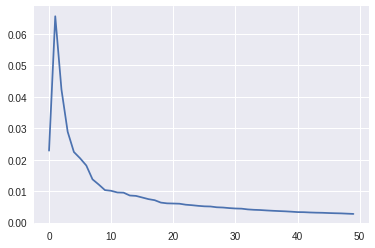

In [27]:
lsa_explore = TruncatedSVD(50, algorithm = 'randomized')
lsa_explore.fit_transform(data)
plt.plot(lsa_explore.explained_variance_ratio_)
sum(lsa_explore.explained_variance_ratio_[:8])

0.25693564686103204

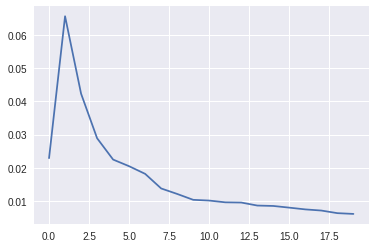

In [28]:
lsa_explore = TruncatedSVD(20, algorithm = 'randomized')
lsa_explore.fit_transform(data)
plt.plot(lsa_explore.explained_variance_ratio_)
sum(lsa_explore.explained_variance_ratio_[:10])

In [191]:
lda = LatentDirichletAllocation(stopwords=n_topics=9,
                                max_iter=200,
                                random_state=42)
test = lda.fit_transform(data)

/home/paul/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:508: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


In [192]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic #%d:" % topic_idx)
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()
feature_names = vect.get_feature_names()
print_top_words(lda, feature_names, 25)

Topic #0:
common attribution attribution licens creativ sport statist cleveland connect input associ press visual critic current see pond home archiv via search post think amanda contamin washington post superimpos nyt pint donut read sampl pleas tri post via busi busi text time

Topic #1:
common attribution attribution licens creativ sport statist cleveland connect input associ press visual critic current see pond home archiv via search post think amanda contamin washington post superimpos nyt pint donut read sampl pleas tri post via busi busi text time

Topic #2:
chart peopl jump jump hoop hoop make peopl jump graphic bar plot kaiser peopl bar chart line post comment reader design junk gelman andrew gelman art kaiser make map andrew dot comment

Topic #3:
common attribution attribution licens creativ sport statist cleveland connect input associ press visual critic current see pond home archiv via search post think amanda contamin washington post superimpos nyt pint donut read sampl p

In [29]:
nmf = NMF(init='nndsvd',n_components=10,max_iter=200, random_state=42)

In [30]:
topic_data = nmf.fit_transform(data)

In [31]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic #%d:" % topic_idx)
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()
feature_names = vect.get_feature_names()
print_top_words(nmf, feature_names, 25)

Topic #0:
machin machin learn kdnugget python data scienc news data prepar prepar algorithm analyt scienc machin scientist data scientist top stori top python librari librari data python librari softwar deep poll workflow scratch learn workflow workflow python

Topic #1:
visual think peopl design say stori storytel would ago present go look realli year game repli us differ lot show inform project principl much product

Topic #2:
chart jump hoop peopl jump hoop make peopl jump graphic bar plot kaiser junk peopl bar chart line reader junk chart design kaiser make gelman andrew gelman art map andrew dot label

Topic #3:
data scienc onlin research paper summer repli great data handler ryan intro berkeley paper undergradu earn syracus degre guidelin list new post theori notifi univers rank stat great scienc deep

Topic #4:
statist stat log chang use log log chang use repli cancel chang imag pingback timer input jqueri sampl click notifi new analysi notifi site via data analysi web imag use 

In [32]:
topic_data.shape

(1729, 10)

## BEGIN CLUSTERING!!!

In [107]:
from sklearn.cluster import DBSCAN, KMeans, AffinityPropagation, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import seaborn as sns

FINAL MODEL

In [242]:
pickle.dump( df, open( "labeled_df.p", "wb" ) )

In [243]:
pickle.dump( topic_idenitfying, open( "topic_identifier.p", "wb" ) )

In [244]:
pickle.dump(agg, open('agg_model.p','wb'))

In [115]:
agg = AgglomerativeClustering(n_clusters=10, affinity='cosine', linkage='average')


In [129]:
# Remove points at origin for use of cosine distance metric
for i,val in enumerate(topic_data):
    if sum(val)==0:
        df.drop(i,axis=0,inplace=True)
        

In [131]:
df.reset_index(inplace=True)
df.drop('index',axis=1,inplace=True)

In [112]:
dropped_zeros_topic_data = [x for x in topic_data if sum(x) != 0]

dropped_zeros_topic_data = np.array(droped_zeros_topic_data)

droped_zeros_topic_data.shape

(1719, 10)

In [116]:
labels = agg.fit_predict(dropped_zeros_topic_data)

In [117]:
labels.shape

(1719,)

In [120]:
df.shape

(1729, 5)

In [133]:
df['cluster'] = labels

In [136]:
topic_idenitfying = pd.DataFrame(dropped_zeros_topic_data)

In [137]:
topic_idenitfying['cluster'] = labels

In [235]:
topic_idenitfying.describe()

,0,1,2,3,4,5,6,7,8,9,cluster,labels
count,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000,1719.000000
mean,0.041140,0.033685,0.019118,0.018324,0.016691,0.025939,0.035850,0.018328,0.020489,0.031867,4.134380,4.650378
std,0.052155,0.038125,0.057100,0.059609,0.044155,0.053430,0.047749,0.053703,0.061298,0.055004,2.516067,3.044956
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.001463,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000
50%,0.005830,0.022482,0.000000,0.000000,0.000000,0.000501,0.015249,0.000000,0.000000,0.007381,4.000000,5.000000
75%,0.090497,0.050423,0.003959,0.007997,0.007031,0.016235,0.056629,0.010007,0.012945,0.041762,6.000000,8.000000
max,0.185770,0.202413,0.249370,0.373660,0.256669,0.280402,0.274697,0.385944,0.451342,0.389829,9.000000,9.000000


In [220]:
topic_distribution_dict = {}
for x in range(10):
    topic_distribution = []
    for y in range(10):
        topic_distribution.append(topic_idenitfying.query('cluster == %s' % x)[y].mean())
    topic_distribution_dict[x] = topic_distribution

for k,v in topic_distribution_dict.items():
    print('cluster:',k, '- highest topic:',v.index(max(v)),'- percentage:' ,max(v))
    print('\n')

cluster: 0 - highest topic: 3 - percentage: 0.2672810409471281


cluster: 1 - highest topic: 6 - percentage: 0.1193406800733428


cluster: 2 - highest topic: 5 - percentage: 0.1338184517164039


cluster: 3 - highest topic: 1 - percentage: 0.0998708216443442


cluster: 4 - highest topic: 0 - percentage: 0.11198161270189418


cluster: 5 - highest topic: 8 - percentage: 0.22812140892834487


cluster: 6 - highest topic: 4 - percentage: 0.15512352700370557


cluster: 7 - highest topic: 2 - percentage: 0.19897524434174402


cluster: 8 - highest topic: 9 - percentage: 0.1642226030399323


cluster: 9 - highest topic: 7 - percentage: 0.22823786064940269




In [190]:
df.query('cluster==7').shape

(145, 5)

In [193]:
for x in range(100,145):
    print(df.query('cluster==7').iloc[x,:]['url'])

http://junkcharts.typepad.com/junk_charts/sports/
http://junkcharts.typepad.com/junk_charts/statistics/
http://junkcharts.typepad.com/junk_charts/sufficiency/
http://junkcharts.typepad.com/junk_charts/superimposed/
http://junkcharts.typepad.com/junk_charts/table/
http://junkcharts.typepad.com/junk_charts/television/
http://junkcharts.typepad.com/junk_charts/text/
http://junkcharts.typepad.com/junk_charts/time_series/
http://junkcharts.typepad.com/junk_charts/tools/
http://junkcharts.typepad.com/junk_charts/travel/
http://junkcharts.typepad.com/junk_charts/trifecta-checkup/
http://junkcharts.typepad.com/junk_charts/variance/
http://junkcharts.typepad.com/junk_charts/washington-post/
http://junkcharts.typepad.com/junk_charts/webtech/
http://junkcharts.typepad.com/junk_charts/weblogs/
http://junkcharts.typepad.com/junk_charts/wikipedia/
http://junkcharts.typepad.com/junk_charts/wired/
http://junkcharts.typepad.com/junk_charts/wsj/
http://junkcharts.typepad.com/junk_charts/2016/09/graphica

In [150]:
print_top_words(nmf, feature_names, 25)

Topic #0:
machin machin learn kdnugget python data scienc news data prepar prepar algorithm analyt scienc machin scientist data scientist top stori top python librari librari data python librari softwar deep poll workflow scratch learn workflow workflow python

Topic #1:
visual think peopl design say stori storytel would ago present go look realli year game repli us differ lot show inform project principl much product

Topic #2:
chart jump hoop peopl jump hoop make peopl jump graphic bar plot kaiser junk peopl bar chart line reader junk chart design kaiser make gelman andrew gelman art map andrew dot label

Topic #3:
data scienc onlin research paper summer repli great data handler ryan intro berkeley paper undergradu earn syracus degre guidelin list new post theori notifi univers rank stat great scienc deep

Topic #4:
statist stat log chang use log log chang use repli cancel chang imag pingback timer input jqueri sampl click notifi new analysi notifi site via data analysi web imag use 

For n_clusters = 10 The average silhouette_score is : 0.335608869572


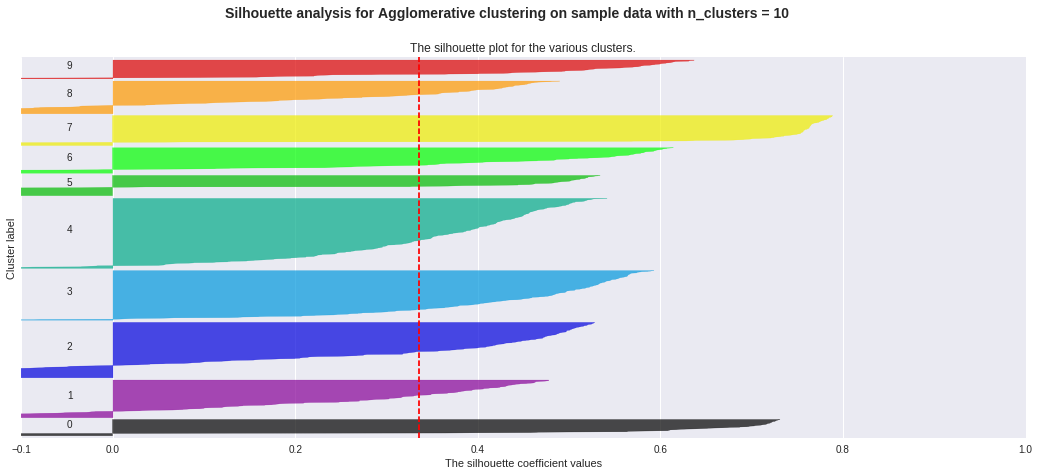

In [149]:
X = dropped_zeros_topic_data
n_clusters = 10

fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

KMclusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(X)

silhouette_avg = silhouette_score(X, cluster_labels)
print("For n_clusters =", n_clusters,
      "The average silhouette_score is :", silhouette_avg)

sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                  0, ith_cluster_silhouette_values,
                  facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([]) 
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(("Silhouette analysis for Agglomerative clustering on sample data "
          "with n_clusters = %d" % n_clusters),
         fontsize=14, fontweight='bold');

In [214]:
for x in range(3,21):
    n_clusters = x

    agg = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='average')

    cluster_labels = agg.fit_predict(droped_zeros_topic_data)

    silhouette_avg = silhouette_score(droped_zeros_topic_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)


For n_clusters = 3 The average silhouette_score is : 0.301214963295
For n_clusters = 4 The average silhouette_score is : 0.334623096772
For n_clusters = 5 The average silhouette_score is : 0.279174683213
For n_clusters = 6 The average silhouette_score is : 0.286965739641
For n_clusters = 7 The average silhouette_score is : 0.287137500063
For n_clusters = 8 The average silhouette_score is : 0.323359254644
For n_clusters = 9 The average silhouette_score is : 0.304605242304
For n_clusters = 10 The average silhouette_score is : 0.335608869572
For n_clusters = 11 The average silhouette_score is : 0.319181769533
For n_clusters = 12 The average silhouette_score is : 0.313650960471
For n_clusters = 13 The average silhouette_score is : 0.299257237156
For n_clusters = 14 The average silhouette_score is : 0.291061249952
For n_clusters = 15 The average silhouette_score is : 0.270120864312
For n_clusters = 16 The average silhouette_score is : 0.261796654224
For n_clusters = 17 The average silhouett

## Add cluster IDs to mongodb

In [10]:
df = pickle.load(open("labeled_df.p","rb"))

In [31]:
df.iloc[10,:]['url']

'http://101.datascience.community/2016/04/19/getting-started-with-data-science-specialties/'

In [32]:
df.iloc[10,:]['cluster']

0

In [33]:
col.find_one({"url":'http://101.datascience.community/2016/04/19/getting-started-with-data-science-specialties/'})['cluster']

0

In [23]:
for x in range(len(df)):
    col.update_one({'url':df.iloc[x,:]['url']},{'$set':{'cluster':int(df.iloc[x,:]['cluster'])}})

In [34]:
col.find( {"cluster": { '$exists': True} } ).distinct("cluster")

[3, 5, 0, 2, 8, 4, 6, 1, 7, 9]

## EVERYTHING AFTER HERE IS LEFT OVER CLUSTERING EXPLORATION THAT SHOULD BE IGNORED UNTIL I AM READY TO CLEAN IT UP

For n_clusters = 10 The average silhouette_score is : 0.335608869572


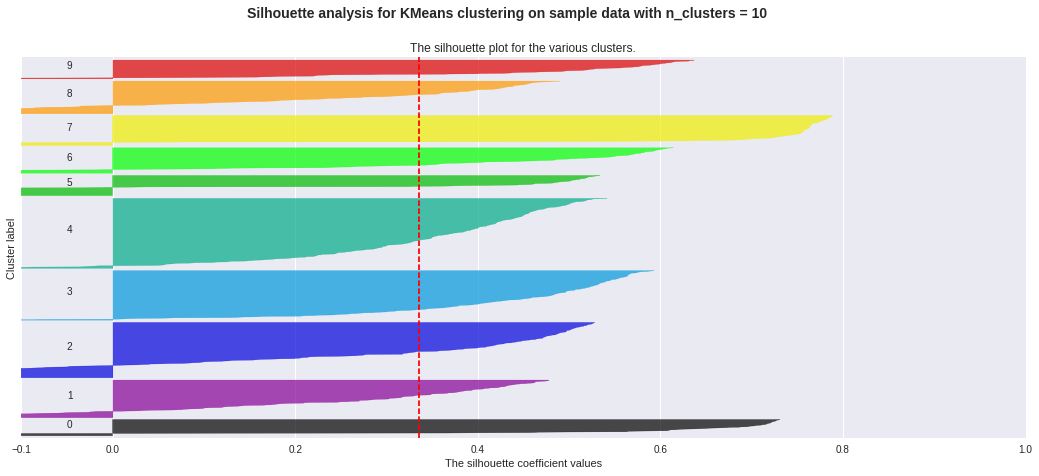

In [215]:
X = dropped_zeros_topic_data
n_clusters = 10   

fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

KMclusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(X)

silhouette_avg = silhouette_score(X, cluster_labels)
print("For n_clusters =", n_clusters,
      "The average silhouette_score is :", silhouette_avg)

sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                  0, ith_cluster_silhouette_values,
                  facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([]) 
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
          "with n_clusters = %d" % n_clusters),
         fontsize=14, fontweight='bold')

In [196]:
KMclusterer = KMeans(n_clusters=10, random_state=10)
cluster_labels = KMclusterer.fit_predict(droped_zeros_topic_data)

In [199]:
df['labels'] = cluster_labels

In [206]:
topic_idenitfying['labels'] = cluster_labels

In [221]:
topic_distribution_dict2 = {}
for x in range(10):
    topic_distribution = []
    for y in range(10):
        topic_distribution.append(topic_idenitfying.query('labels == %s' % x)[y].mean())
    topic_distribution_dict2[x] = topic_distribution

for k,v in topic_distribution_dict2.items():
    print('cluster: ',k, ' - highest topic: ',v.index(max(v)),' - percentage: ' ,max(v))
    print('\n')

cluster:  0  - highest topic:  2  - percentage:  0.21758655437072016


cluster:  1  - highest topic:  5  - percentage:  0.16108092250630637


cluster:  2  - highest topic:  1  - percentage:  0.08537043864411074


cluster:  3  - highest topic:  7  - percentage:  0.23554187857810896


cluster:  4  - highest topic:  3  - percentage:  0.30155875700264406


cluster:  5  - highest topic:  8  - percentage:  0.33350999993848424


cluster:  6  - highest topic:  4  - percentage:  0.17137447074027568


cluster:  7  - highest topic:  6  - percentage:  0.12974030901018493


cluster:  8  - highest topic:  0  - percentage:  0.11344146357049928


cluster:  9  - highest topic:  9  - percentage:  0.2059314307283121




In [202]:
print_top_words(nmf, feature_names, 25)

Topic #0:
machin machin learn kdnugget python data scienc news data prepar prepar algorithm analyt scienc machin scientist data scientist top stori top python librari librari data python librari softwar deep poll workflow scratch learn workflow workflow python

Topic #1:
visual think peopl design say stori storytel would ago present go look realli year game repli us differ lot show inform project principl much product

Topic #2:
chart jump hoop peopl jump hoop make peopl jump graphic bar plot kaiser junk peopl bar chart line reader junk chart design kaiser make gelman andrew gelman art map andrew dot label

Topic #3:
data scienc onlin research paper summer repli great data handler ryan intro berkeley paper undergradu earn syracus degre guidelin list new post theori notifi univers rank stat great scienc deep

Topic #4:
statist stat log chang use log log chang use repli cancel chang imag pingback timer input jqueri sampl click notifi new analysi notifi site via data analysi web imag use 

In [217]:
df.query('labels==4').shape

(67, 6)

In [218]:
for x in range(67):
    print(df.query('labels == 4').iloc[x,:]['url'])

http://101.datascience.community/2016/09/22/data-science-and-the-perfect-team/
http://101.datascience.community/2016/04/19/getting-started-with-data-science-specialties/
http://101.datascience.community/2014/10/17/data-sources-for-cool-data-science-projects-part-1-guest-post/
http://101.datascience.community/2014/10/17/data-sources-for-cool-data-science-projects-part-2-guest-post/
http://101.datascience.community/2016/06/16/how-to-kickstart-your-data-science-career/
http://101.datascience.community/2016/04/21/tips-for-future-data-scientists/
http://101.datascience.community/2015/12/21/the-most-popular-skills-and-degrees-of-todays-data-scientists/
http://101.datascience.community/2015/05/26/data-science-startups-and-sex-trafficking/
http://101.datascience.community/2013/06/11/deep-learning-a-term-to-know/
http://101.datascience.community/
http://101.datascience.community/2016/08/24/recent-resources-for-open-data/
http://101.datascience.community/2016/11/12/our-world-in-data/
http://101.